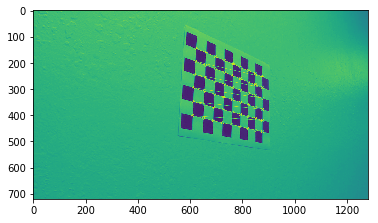

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
nx = 9
ny = 6

cam_img_path = glob.glob("./camera_cal/calibration*.jpg")
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
objps = []
imgps = []
for file in cam_img_path:
    test_img = cv2.imread(file)
    test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    # Find corners
    ret, corners = cv2.findChessboardCorners(test_img_gray, (nx, ny), None)
    if ret == True:
        # store object points and image points
        objps.append(objp)
        imgps.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(test_img_gray, (nx, ny), corners, ret)
        plt.imshow(test_img_gray)

In [20]:
# undistortion
test_img = cv2.imread(cam_img_path[0])
img_size = (test_img.shape[1], test_img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objps, imgps, img_size,None,None)
dst = cv2.undistort(test_img, mtx, dist, None, mtx)

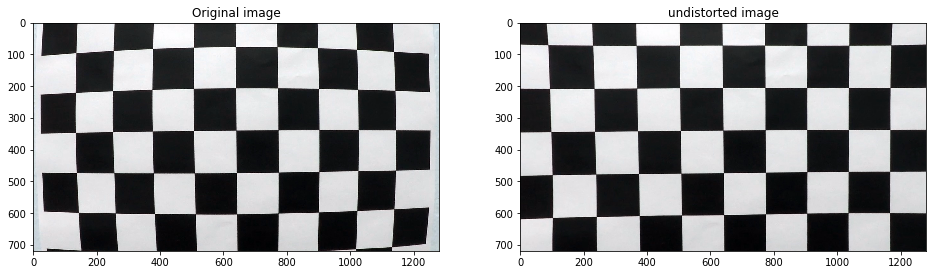

In [25]:
%matplotlib inline
fig=plt.figure(figsize=(16, 16))
fig.add_subplot(1,2,1)
plt.imshow(test_img)
plt.title("Original image")
fig.add_subplot(1,2,2)
plt.imshow(dst)
plt.title("undistorted image")

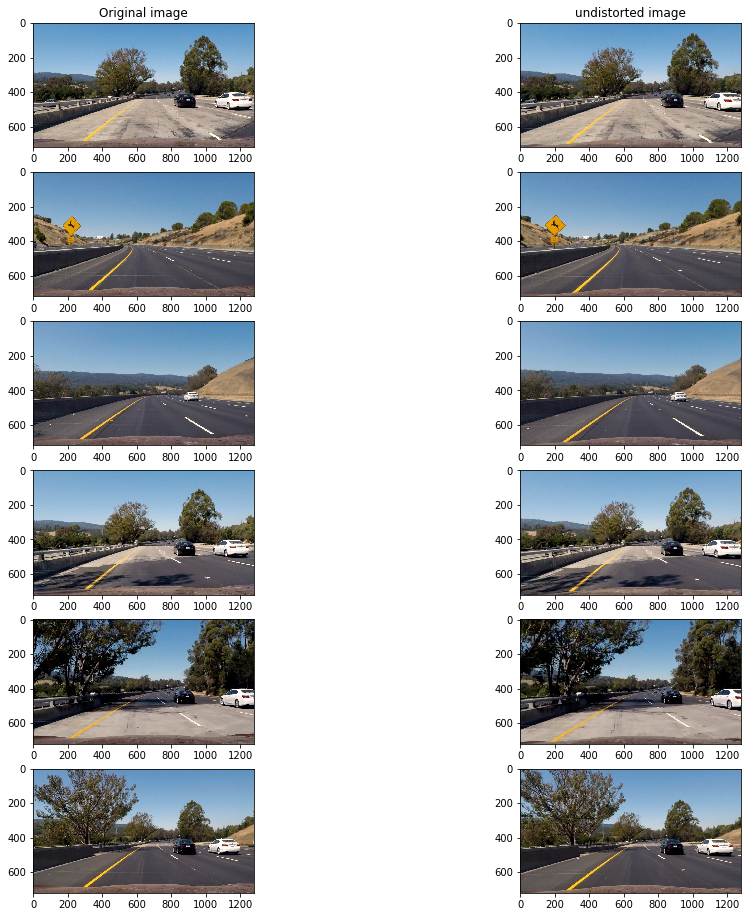

In [31]:
# Test for image
test_img_path = glob.glob("./test_images/test*.jpg")
fig=plt.figure(figsize=(16, 16))
num_file = len(test_img_path)
for i in range(num_file):
    tmp_img = plt.imread(test_img_path[i])
    dst = cv2.undistort(tmp_img, mtx, dist, None, mtx)
    fig.add_subplot(num_file, 2, i * 2 + 1)
    plt.imshow(tmp_img)
    if i == 0:
        plt.title("Original image")
    fig.add_subplot(num_file, 2, i * 2 + 2)
    plt.imshow(dst)
    if i == 0:
        plt.title("undistorted image")

In [37]:
def unwarp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

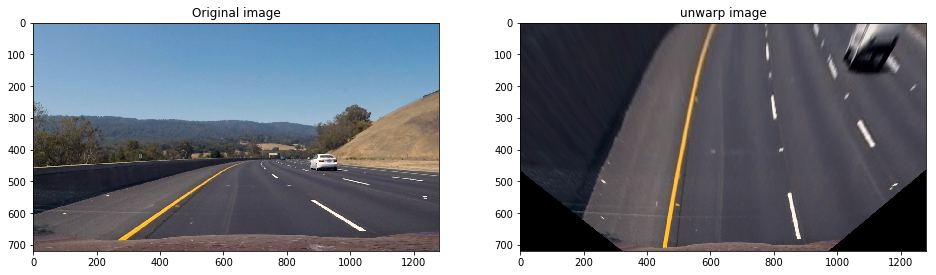

In [46]:
img = plt.imread(test_img_path[2])
height = img.shape[0]
width = img.shape[1]
src = np.float32([(550,450),
                  (750,450), 
                  (250,700), 
                  (1000,700)])
dst = np.float32([(450,0),
                  (width-450,0),
                  (450,height),
                  (width-450,height)])
img_unwarp, M, Minv = unwarp(img, src, dst)
fig=plt.figure(figsize=(16, 16))
fig.add_subplot(1,2,1)
plt.imshow(img)
plt.title("Original image")
fig.add_subplot(1,2,2)
plt.imshow(img_unwarp)
plt.title("unwarp image")

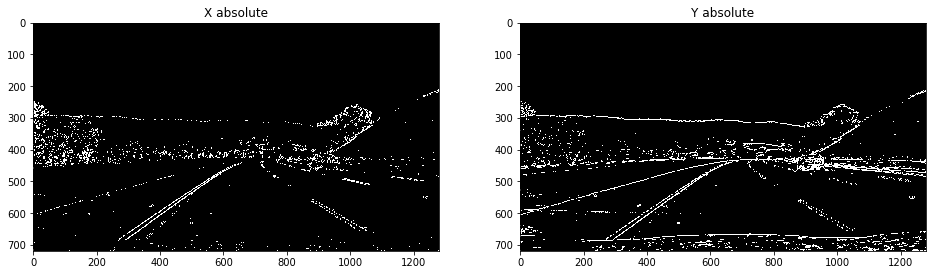

In [70]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output

abs_img_x = abs_sobel_thresh(img, thresh_min = 20, thresh_max = 100)
abs_img_y = abs_sobel_thresh(img, orient = 'y', thresh_min = 20, thresh_max = 100)
fig=plt.figure(figsize=(16, 16))
fig.add_subplot(1,2,1)
plt.imshow(abs_img_x, cmap = 'gray')
plt.title("X absolute")
fig.add_subplot(1,2,2)
plt.imshow(abs_img_y, cmap = 'gray')
plt.title("Y absolute")

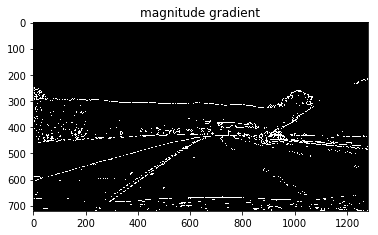

In [72]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

mag_img = mag_thresh(img, mag_thresh = (30, 100))
plt.imshow(mag_img, cmap = 'gray')
plt.title("magnitude gradient")

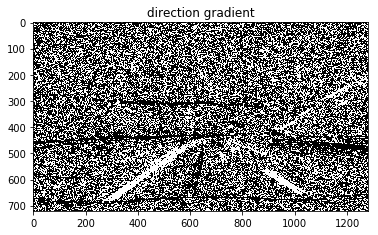

In [73]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return binary_output
dir_img = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
plt.imshow(dir_img, cmap = 'gray')
plt.title("direction gradient")

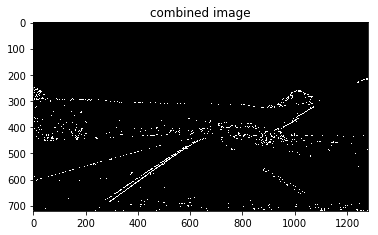

In [75]:
combined = np.zeros_like(dir_img)
combined[((abs_img_x == 1) & (abs_img_y == 1)) | ((mag_img == 1) & (dir_img == 1))] = 1
plt.imshow(combined, cmap = 'gray')
plt.title("combined image")

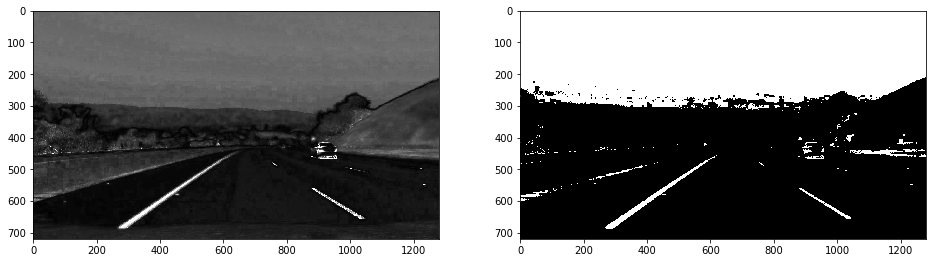

In [82]:
# test hls colorspace
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
thresh_S = (90, 255)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
fig=plt.figure(figsize=(16, 16))
fig.add_subplot(1,2,1)
plt.imshow(S, cmap = 'gray')
binary_S = np.zeros_like(S)
binary_S[(S > thresh_S[0]) & (S <= thresh_S[1])] = 1
fig.add_subplot(1,2,2)
plt.imshow(binary_S, cmap = 'gray')

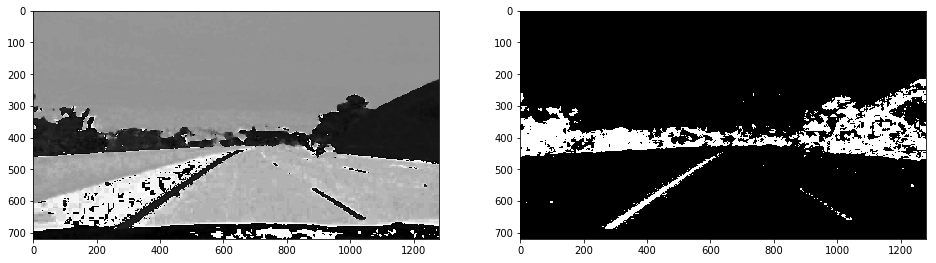

In [83]:
thresh_H = (15, 100)
binary_H = np.zeros_like(H)
binary_H[(H > thresh_H[0]) & (H <= thresh_H[1])] = 1
fig=plt.figure(figsize=(16, 16))
fig.add_subplot(1,2,1)
plt.imshow(H, cmap = 'gray')
binary_H = np.zeros_like(H)
binary_H[(H > thresh_H[0]) & (H <= thresh_H[1])] = 1
fig.add_subplot(1,2,2)
plt.imshow(binary_H, cmap = 'gray')

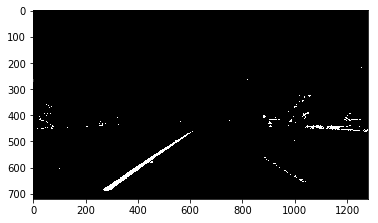

In [85]:
# combine colorspace result
combined_c = np.zeros_like(H)
combined_c[(binary_S == 1) & (binary_H == 1)] = 1
plt.imshow(combined_c, cmap = 'gray')

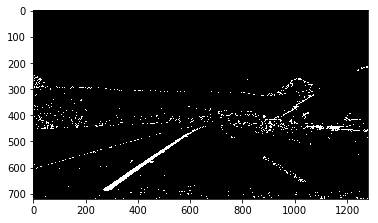

In [88]:
# combine colorspace and gradient result
result = np.zeros_like(combined)
result[(combined == 1) | (combined_c == 1)] = 1
plt.imshow(result, cmap = 'gray')

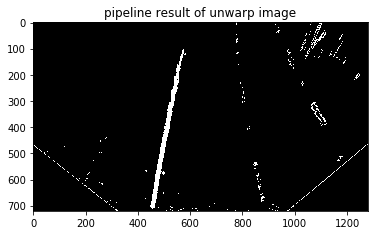

In [92]:
# connect entire pipeline
def pipeline(img):
    # gradient thresholding
    abs_img_x = abs_sobel_thresh(img, thresh_min = 20, thresh_max = 100)
    abs_img_y = abs_sobel_thresh(img, orient = 'y', thresh_min = 20, thresh_max = 100)
    mag_img = mag_thresh(img, mag_thresh = (30, 100))
    dir_img = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    combined = np.zeros_like(dir_img)
    combined[((abs_img_x == 1) & (abs_img_y == 1)) | ((mag_img == 1) & (dir_img == 1))] = 1
    # colorspace thresholding
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    thresh_S = (90, 255)
    thresh_H = (15, 100)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary_S = np.zeros_like(S)
    binary_H = np.zeros_like(H)
    binary_S[(S > thresh_S[0]) & (S <= thresh_S[1])] = 1
    binary_H[(H > thresh_H[0]) & (H <= thresh_H[1])] = 1
    combined_c = np.zeros_like(H)
    combined_c[(binary_S == 1) & (binary_H == 1)] = 1
    # combine all
    result = np.zeros_like(combined)
    result[(combined == 1) | (combined_c == 1)] = 1
    return result
test_img = pipeline(img_unwarp)
plt.imshow(test_img, cmap = 'gray')
plt.title("pipeline result of unwarp image")